# Privacy-Preserving Image Style Transfer with Concrete ML

This notebook describes a way to perform style transfer on images in a privacy-preserving way. As a part of this experiment, we first train a style transfer network and then use FHE(Fully Homomorphic Encryption) to perform style transfer on encrypted images(in a privacy-preserving way). We have used Concrete-ML library which uses THFE encryption scheme. While implementing privacy-preserving style transfer, we have made the following choices -   
* Running a neural network with Concrete ML requires quantization of parameters. So, there are two ways to create FHE-compatible neural networks - quantization aware training networks and post training quantization. We have gone with later approach.
* While implementing the FHE-compatible network, we often encountered `NotImplemented` for a lot of ONNX operators. We had add some custom logic and hacks(explained later) to make our network run.
* Since a large model takes a lot of time to compile(and inference), we decided to use a smaller network.
* As a smaller network is being used, we decided to train our network on CIFAR-100 dataset which has image dimension of 32X32. 

In [1]:
import torch
from torch.autograd import Variable
from collections import namedtuple
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import os
import sys
import random
from PIL import Image
import glob
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import zoom
import onnx
import brevitas
import brevitas.nn as qnn
import concrete.ml as cml
from concrete.ml.torch.compile import compile_torch_model, compile_onnx_model, compile_brevitas_qat_model
device = torch.device("mps")

In [3]:
print("Python version: ", sys.version)
# PyTorch version
print("PyTorch version: ", torch.__version__)
# Concrete ML version
print("Concrete ML version: ", cml.__version__)
# Brevitas version
print("Brevitas version: ", brevitas.__version__)

Python version:  3.9.19 (main, Mar 19 2024, 16:08:27) 
[Clang 15.0.0 (clang-1500.3.9.4)]
PyTorch version:  2.4.0
Concrete ML version:  1.6.1
Brevitas version:  0.8.0


## Defining the Neural Style Transfer Model
The neural style transfer model defined below was introduced in the paper - [Leon A. Gatys, Alexander S. Ecker and Matthias Bethge](https://arxiv.org/pdf/1508.06576). For style-transform network architecture and training, we have used [this kaggle notebook](https://www.kaggle.com/code/yashchoudhary/fast-neural-style-transfer). However, we had to make some changes to the network architecture to make it FHE-compatible and run it in reasonable time using Concrete ML. Few of the changes are - 
* **Network Architecture Changes:-** Size of layes have been made smaller. The size of `ResidualBlock` has been changed from `128` to `32`. The size of `ConvBlock`s at the start and end have also been reduced i.e `(3,32) -> (3, 8)`, `(32, 64) -> (8, 16)`, `(64, 128) -> (16, 32)`. The `kernel_size` in the first and last layer has also been reduced from `9` to `3`.
* **Padding Changes:-** In the original paper, it is recommended to use `reflection` padding for better results. However, support for reflection padding is not present in Concrete ML. So, we used `constant` padding instead. Constant padding introduces edge/border effect while working with convolutional layers. But, since we trained our network on tiny images, this effect was not evidient.
* **Normalization Changes:-** In the original paper, it is recommended to use `Instance` normalization for better results. However, support for instance normalisation is not present in Concrete ML. So, we used `Batch` normalization instead.
* **Upsampling changes:-** In the penultimate layer and the layer before that, we need to upsample the input before applying `ConvBlock`. However, native support for upsampling(interpolation or Resize operator in ONNX graph) is not present in Concrete ML. So, we had to add custom logic for upsampling(nearest neighbour interpolation) which can be compiled using Concrete ML.

In [2]:
""" Transformer Net """
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 8, kernel_size=3, stride=1),
            ConvBlock(8, 16, kernel_size=3, stride=2),
            ConvBlock(16, 32, kernel_size=3, stride=2),
            ResidualBlock(32),
            ResidualBlock(32),
            ResidualBlock(32),
            ResidualBlock(32),
            ResidualBlock(32),
            ConvBlock(32, 16, kernel_size=3, upsample=True),
            ConvBlock(16, 8, kernel_size=3, upsample=True),
            ConvBlock(8, 3, kernel_size=3, stride=1, normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)


""" Components of Transformer Net """
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.kernel_size = kernel_size
        self.block = nn.Sequential(
            nn.ConstantPad2d(kernel_size // 2, 0), 
            nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.BatchNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu
        
    def interpolate(self, x, scale_factor):
        #Hack used because of some bug in Concrete ML/ONNX that can't infer size of x dynamically
        batch_size, channels, height, width = x.shape
        if x.shape[1] == 32:
            batch_size, channels, height, width = (1, 32, 8, 8)
        else:
            batch_size, channels, height, width = (1, 16, 16, 16)
            
        # Along width-axis
        x = x.unsqueeze(-1)
        x = x.expand(batch_size, channels, height, width, scale_factor)
        x = x.reshape(batch_size, channels, height, width*scale_factor)
        # Along height-axis
        x = x.transpose(2,3).unsqueeze(-1)
        x = x.expand(batch_size, channels, width*scale_factor, height, scale_factor)
        x = x.reshape(batch_size, channels, width*scale_factor, height*scale_factor).transpose(2,3)
            
        return x

        
    def forward(self, x):
        if self.upsample:
            x = self.interpolate(x, 2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x

## Loading a pre-trained Style Transfer Network
As mentioned in the above paper, we train a style-transfer network for a particulat style. When a content image is passed through the trained network, that particular style is applied. In this case, we have trained our network for the following style image(Mosaic) - 
<div><img src="style/mosaic.jpg"></div>

In [3]:
checkpoint_model = 'checkpoints/Mosaic-last_checkpoint.pth'
transformer = TransformerNet()
transformer.load_state_dict(torch.load(checkpoint_model, map_location=torch.device('mps')))
transformer.eval()

/var/folders/pg/4x87lmm104dd722_rr2fzq6w0000gq/T/ipykernel_8120/2724799945.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load(checkpo

TransformerNet(
  (model): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
        (1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
      )
      (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
        (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
      )
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
        (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      )
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ResidualBlock(
      (block): Sequential(
        (0): ConvBlock(
          (block): Sequential(
            (0): ConstantPad2d(

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


def test_transform(image_size=None):
    """ Transforms for test image """
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform
    
def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c] = tensors[:, c] * std[c] + mean[c]
    return tensors

### Preparing input for model
We will read an image from the CIFAR-100 dataset and pass that as an sample input while creating a FHE-compatible model.

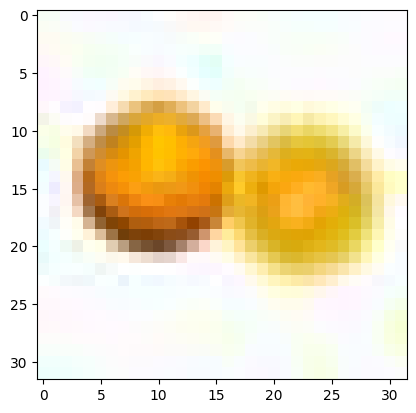

In [103]:
content_path = './cifar-dataset/cifar100/632.jpg'
transform = test_transform()
image = Image.open(content_path)
img_tensor = Variable(transform(image))
img_tensor = img_tensor.unsqueeze(0)
plt.imshow(cv2.cvtColor(cv2.imread(content_path), cv2.COLOR_BGR2RGB))

In [24]:
print(img_tensor.shape)
print(img_tensor.numpy().shape)

torch.Size([1, 3, 32, 32])
(1, 3, 32, 32)


## Creating a FHE-compatible model and Inferencing on Encrypted data
Now that we have a pre-trained model for a particular style, we can create a FHE-compatible model using Concrete ML. As stated earlier, we are doing post-training quantization for our pre-trained model. We use `n_bits=5` and `rounding_threshold_bits=7` which generated good results.

In [9]:
private_model = compile_torch_model(
    transformer, 
    img_tensor, 
    n_bits=5,
    rounding_threshold_bits={"n_bits": 7, "method": "approximate"}
)

/var/folders/pg/4x87lmm104dd722_rr2fzq6w0000gq/T/ipykernel_8120/352451276.py:95: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[1] == 32:
[cctools-port]: generating fake signature for '/var/folders/pg/4x87lmm104dd722_rr2fzq6w0000gq/T/tmpc1sy052v/sharedlib.dylib'


In [63]:
y_pred = private_model.forward(img_tensor.numpy(), fhe="execute")

In [64]:
y_pred.shape

(1, 3, 32, 32)

In [65]:
res = denormalize(y_pred)
res.shape

(1, 3, 32, 32)

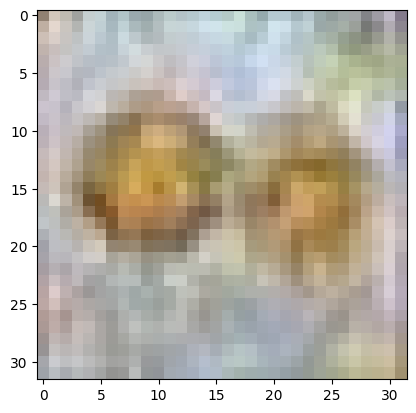

In [66]:
save_image(torch.tensor(res), './results/private-632.jpg')
plt.imshow(cv2.cvtColor(cv2.imread('./results/private-632.jpg'), cv2.COLOR_BGR2RGB))

## Testing and Results
We had trained our network using 50000 CIFAR-100 images. So, we FHE-compatible model on 3 train images(1 images already evaluated) and pick 5 images out of 10000 CIFAR-100 test images. We observed that inference time for each image is about ~53 minutes.

In [43]:
import time

def get_img(content_path):
    transform = test_transform()
    image = Image.open(f'./cifar-dataset/cifar100/{content_path}')
    img_tensor = Variable(transform(image))
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

def generate_style_image(content_paths):
    for content_path in content_paths:
        start_time = time.time()
        img_tensor = get_img(content_path)
        y_pred = private_model.forward(img_tensor.numpy(), fhe="execute")
        res = denormalize(y_pred)
        save_image(torch.tensor(res), f'./results/private-{content_path}')
        print("Total time = ", time.time() - start_time)

In [11]:
train_content_paths = ['10.jpg', '6327.jpg']
generate_style_image(train_content_paths)

Total time =  3296.2640430927277
Total time =  3256.2528188228607


In [15]:
test_content_paths = ['59801.jpg', '59665.jpg', '59689.jpg', '59776.jpg', '59796.jpg']
generate_style_image(test_content_paths)

Total time =  3137.6475491523743
Total time =  3188.5285189151764
Total time =  3154.049906015396
Total time =  3072.808310985565
Total time =  3120.745586156845


In [109]:
from torchvision.io import read_image 

content_paths = ['632.jpg'] + train_content_paths + test_content_paths
n_imgs = len(content_paths)
ori_imgs = []
ori_style_imgs = []
private_style_imgs = []
transform = transforms.Compose([
    transforms.ToTensor()
])

for content_path in content_paths:
    ori_img = cv2.cvtColor(cv2.imread(f'./cifar-dataset/cifar100/{content_path}'), cv2.COLOR_BGR2RGB)
    ori_imgs.append(transform(ori_img))
    private_style_img = cv2.cvtColor(cv2.imread(f'./results/private-{content_path}'), cv2.COLOR_BGR2RGB)
    private_style_imgs.append(transform(private_style_img))
    fn = content_path.split('/')[-1].split('.')[0]
    ori_style_img = cv2.cvtColor(cv2.imread(f'./results/{fn}-output.jpg'), cv2.COLOR_BGR2RGB)
    ori_style_imgs.append(transform(ori_style_img))


In [114]:
ori_img_grid = torch.stack(ori_imgs)
save_image(ori_img_grid, "./results/original-grid.jpg", nrow=n_imgs)
private_style_img_grid = torch.stack(private_style_imgs)
save_image(private_style_img_grid, "./results/private-style-grid.jpg", nrow=n_imgs)
ori_style_img_grid = torch.stack(ori_style_imgs)
save_image(ori_style_img_grid, "./results/original-style-grid.jpg", nrow=n_imgs)

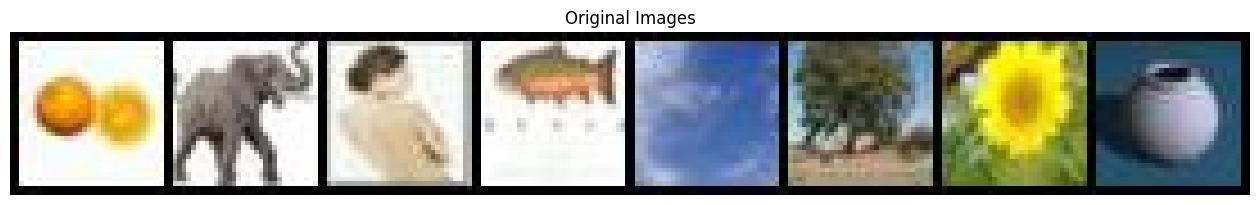

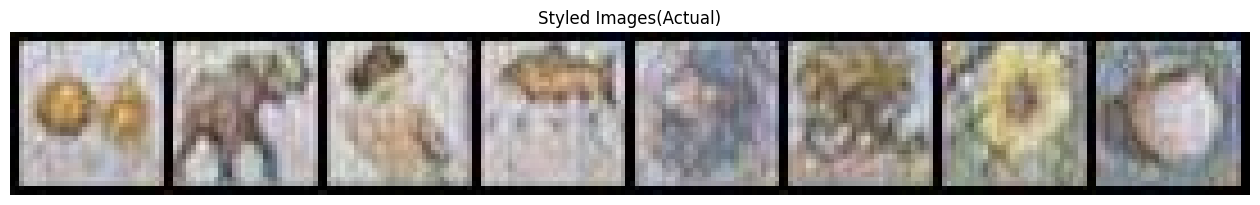

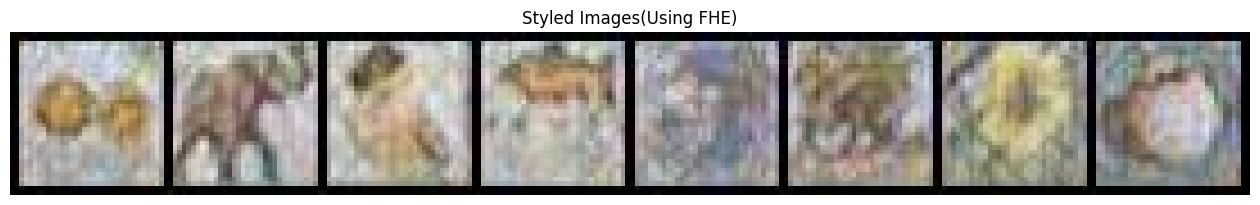

In [145]:
images = ori_imgs + private_style_imgs

fig, axes = plt.subplots(1, 1, figsize=(16, 16)) 

axes.imshow(cv2.cvtColor(cv2.imread("./results/original-grid.jpg"), cv2.COLOR_BGR2RGB))
axes.axis("off")
axes.set_title("Original Images")

fig, axes = plt.subplots(1, 1, figsize=(16, 16)) 
axes.imshow(cv2.cvtColor(cv2.imread("./results/original-style-grid.jpg"), cv2.COLOR_BGR2RGB))
axes.axis("off")
axes.set_title("Styled Images(Actual)")

fig, axes = plt.subplots(1, 1, figsize=(16, 16)) 
axes.imshow(cv2.cvtColor(cv2.imread("./results/private-style-grid.jpg"), cv2.COLOR_BGR2RGB))
axes.axis("off")
axes.set_title("Styled Images(Using FHE)")

plt.show()